# Exploratory Data Analysis Pt 1

## Music Extraction Features

At this point I've completed constructing my db and now I want to get to know the data provided to me by Essentia and its models

In this first part of the EDA, I'm looking at the data produced by essentia's [Music Extractor tool](https://essentia.upf.edu/streaming_extractor_music.html)

In [1]:
#Imports
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
from tqdm import tqdm
import pathlib
import librosa
import taglib
import warnings
warnings.filterwarnings('ignore')

In [21]:
#Imports from project package called project_tools
from project_tools.utils import adapt_array, convert_array, tag_cleaner, json_opener

In [3]:
#Register these functions with sqlite3 so that we I can work with 
sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

In [4]:
#Connect to db
conn = sqlite3.connect("jaage.db", detect_types= sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()

Here are the tables in my database

In [5]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()
tables

[('effnet_embeddings',),
 ('files',),
 ('tonal_features',),
 ('lowlevel_features',),
 ('rhythm_features',),
 ('approachability_2c_effnet_discogs_1_activations',),
 ('danceability_effnet_discogs_1_activations',),
 ('engagement_2c_effnet_discogs_1_activations',),
 ('genre_electronic_effnet_discogs_1_activations',),
 ('mood_acoustic_effnet_discogs_1_activations',),
 ('mood_aggressive_effnet_discogs_1_activations',),
 ('mood_happy_effnet_discogs_1_activations',),
 ('mood_party_effnet_discogs_1_activations',),
 ('mood_sad_effnet_discogs_1_activations',),
 ('mtg_jamendo_genre_effnet_discogs_1_activations',),
 ('mtg_jamendo_moodtheme_effnet_discogs_1_activations',),
 ('mtg_jamendo_top50tags_effnet_discogs_1_activations',),
 ('timbre_effnet_discogs_1_activations',),
 ('lowlevel_barkbands_mean_tbl',),
 ('lowlevel_barkbands_stdev_tbl',),
 ('lowlevel_erbbands_mean_tbl',),
 ('lowlevel_erbbands_stdev_tbl',),
 ('lowlevel_gfcc_mean_tbl',),
 ('lowlevel_melbands_mean_tbl',),
 ('lowlevel_melbands_stdev_

The point of this notebook is essentially kick the tires on this dataset, basically audit what's available.

**Files**

In [6]:
files = pd.read_sql_query("SELECT * FROM files", con = conn)
files.head()

,sid,file_path
0,b806881a54bdbf9dd93a290716adf191,../../../../Volumes/LaCie/Collection/04 House ...
1,46e54d2ab920a088b77382e04877141b,../../../../Volumes/LaCie/Collection/Alex Virg...
2,a204ddef5763df6d8f7677701fe9d96f,../../../../Volumes/LaCie/Collection/01 Protos...
3,960097894e83c5810a9c649f17a4e551,../../../../Volumes/LaCie/Collection/Cristal -...
4,a3c1f277aa0110ffc418bf5fa3aa16aa,../../../../Volumes/LaCie/Collection/Maya - La...


This table links the file paths of my music collection with the unique IDs generated by essentia's music features extraction tool

`sid` short for song id is the name unique id column for every table

### Music Extraction Features

**Tags**

In [7]:
tags = pd.read_sql_query("SELECT * FROM tags", con = conn).set_index("sid")
tags.tail(7)

,length,gain,codec,file_name,bpm,initialkey,title,album,artist,date,genre,label
sid,,,,,,,,,,,,
dbd0bcd737d1fa5e1d2d297d837eb06b,573.358704,-14.331869,pcm_s24le,FONDA RAE - TUCH ME ( 1986 DISCO ).wav,NaN,None,FONDA RAE - TUCH ME ( 1986 DISCO ),None,Adjslife,2009,None,None
11b9acbea92105f6e55453f9792a5beb,124.812492,-12.523500,pcm_s24le,Fonda Rae- Tuch me (JD 1991 Vapor Dub Intro).wav,NaN,None,Fonda Rae- Tuch me (JD 1991 Vapor Dub Intro),None,Foamek,2019,None,None
3d7b510d54ff812806f639439a65f6f6,269.578796,-13.367760,pcm_s24le,Jitter - Juicy Jr And Bliss Maxell - You Got M...,NaN,None,None,None,None,None,None,None
eecda4d92d017dc21d93af9877c94c78,295.250000,-14.490871,pcm_s24le,JR.Dynamite Edits - Fonda Rae - Touch Me (JR.D...,NaN,None,None,None,None,None,None,None
0bc10c3d2e0dafc563595dec1badcca3,241.840302,-13.624350,pcm_s24le,JR.Dynamite Edits - Jungle Boogie (JR.Dynamite...,NaN,None,None,None,None,None,None,None
27b76d3ec7620c0ae1177e251b531c77,308.237396,-13.163139,pcm_s24le,JR.Dynamite Edits - Let Me Show You (JR.Dynami...,NaN,None,None,None,None,None,None,None
a917c2e139050eb78d68d963fd4e2da9,326.844086,-13.163805,pcm_s24le,JR.Dynamite Edits - Ren Woods - Get it Right (...,NaN,None,None,None,None,None,None,None


In [8]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3337 entries, b806881a54bdbf9dd93a290716adf191 to a917c2e139050eb78d68d963fd4e2da9
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   length      3337 non-null   float64
 1   gain        3337 non-null   float64
 2   codec       3337 non-null   object 
 3   file_name   3337 non-null   object 
 4   bpm         3216 non-null   float64
 5   initialkey  2680 non-null   object 
 6   title       3267 non-null   object 
 7   album       1476 non-null   object 
 8   artist      2360 non-null   object 
 9   date        1037 non-null   object 
 10  genre       287 non-null    object 
 11  label       185 non-null    object 
dtypes: float64(3), object(9)
memory usage: 338.9+ KB


This table contains the metadata for the song collection such as important info like title, artist, bpm, and key

This data was collected using the music features extraction tool, but not generated by it. The metadata is already attached to the song file.

BPM Distribution

In [9]:
#Filter out 0 bpm
bpm = tags.query("bpm > 0").bpm

In [10]:
bpm.describe()

count    2634.000000
mean      117.507973
std         9.518214
min        70.000000
25%       114.000000
50%       120.000000
75%       124.000000
max       165.000000
Name: bpm, dtype: float64

This is pretty much to be expected for a DJ such as myself who plays house, funk, disco, and boogie

Visualize distribution

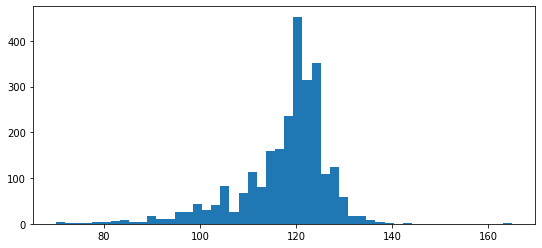

In [11]:
bpm.hist(bins = 50, figsize=(9, 4),grid = False);

Most common keys

In [12]:
keys = tags.initialkey.dropna()

In [13]:
keys.value_counts()

9A     373
8A     367
5A     293
4A     241
7A     235
6A     228
1A     150
2A     147
10A    138
11A    120
12A    104
3A      94
12B     25
8B      24
6B      20
9B      16
7B      16
4B      15
10B     14
3B      12
11B     11
1B      11
5B       9
5b       7
2B       4
7m       3
11m      1
5m       1
7d       1
Name: initialkey, dtype: int64

I prefer the camelot scale which encodes song key and scale as numbers.

![](https://c.neevacdn.net/image/fetch/s--HF6z9snx--/https%3A//pyramind.com/wp-content/uploads/2020/05/preview-lightbox-CamelotWheel-1.jpg?savepath=preview-lightbox-CamelotWheel-1.jpg)

('tonal_features',),
 ('lowlevel_features',),
 ('rhythm_features',),

### Tonal features

In [14]:
tonal = pd.read_sql_query("SELECT * FROM tonal_features", index_col=['sid'], con = conn)
tonal.head()

,tonal_chords_changes_rate,tonal_chords_number_rate,tonal_chords_strength_mean,tonal_chords_strength_stdev,tonal_hpcp_crest_mean,tonal_hpcp_crest_stdev,tonal_hpcp_entropy_mean,tonal_hpcp_entropy_stdev,tonal_key_edma_strength,tonal_key_edma_key,...,tonal_key_krumhansl_scale,tonal_key_temperley_strength,tonal_key_temperley_key,tonal_key_temperley_scale,tonal_tuning_diatonic_strength,tonal_tuning_equal_tempered_deviation,tonal_tuning_frequency,tonal_tuning_nontempered_energy_ratio,tonal_chords_key,tonal_chords_scale
sid,,,,,,,,,,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,0.125525,0.001616,0.470475,0.069027,12.581001,5.755760,2.164732,0.779386,0.502125,C,...,major,0.520859,C,major,0.587632,0.150275,434.193115,0.881876,G,minor
46e54d2ab920a088b77382e04877141b,0.104863,0.002387,0.524884,0.118924,11.273207,5.629401,2.379997,0.772079,0.408560,D,...,major,0.424187,A,major,0.291458,0.197115,438.224518,0.868446,B,major
a204ddef5763df6d8f7677701fe9d96f,0.122595,0.001230,0.406664,0.095949,11.530407,7.164842,2.532152,0.983758,0.766319,E,...,major,0.760266,E,major,0.644248,0.140634,434.193115,0.818142,C,major
960097894e83c5810a9c649f17a4e551,0.043667,0.000868,0.559635,0.097361,12.221793,5.350279,2.142329,0.678882,0.653490,F,...,major,0.620772,F,major,0.530602,0.181902,434.193115,0.900062,C,minor
a3c1f277aa0110ffc418bf5fa3aa16aa,0.050448,0.001227,0.525044,0.089814,13.811895,5.832396,1.891747,0.636924,0.613022,G,...,minor,0.643362,G,minor,0.551057,0.006728,440.000000,0.687000,G,minor


In [22]:
tonal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3338 entries, b806881a54bdbf9dd93a290716adf191 to a917c2e139050eb78d68d963fd4e2da9
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tonal_chords_changes_rate              3338 non-null   float64
 1   tonal_chords_number_rate               3338 non-null   float64
 2   tonal_chords_strength_mean             3338 non-null   float64
 3   tonal_chords_strength_stdev            3338 non-null   float64
 4   tonal_hpcp_crest_mean                  3338 non-null   float64
 5   tonal_hpcp_crest_stdev                 3338 non-null   float64
 6   tonal_hpcp_entropy_mean                3338 non-null   float64
 7   tonal_hpcp_entropy_stdev               3338 non-null   float64
 8   tonal_key_edma_strength                3338 non-null   float64
 9   tonal_key_edma_key                     3338 non-null   object 
 10  tonal_key_edma_sca

This description explains some of the features shown above:

**tuning_frequency**: estimated tuning frequency Hz

**hpcp**: 32-dimensional harmonic pitch class profile (HPCP) 

**hpcp_entropy**: Shannon entropy of a HPCP vector

**hpcp_crest**: crest of the HPCP vector.

**key_temperley, key_krumhansl, key_edma**; key estimation, its scale and strength using three different HPCP key profiles

**tuning_diatonic_strength**: key strength estimated from high-resolution HPCP (120 dimensions) using diatonic profile. 

At this point in my project, I'm not too familiar with this data nor do I have any immediate need to use. However I do believe that some time in the future it could yield benefits.

For now I am interested in key and scale features as potential alternatives to the metadata key and scale.

In [23]:
tonal.tonal_chords_key

sid
b806881a54bdbf9dd93a290716adf191     G
46e54d2ab920a088b77382e04877141b     B
a204ddef5763df6d8f7677701fe9d96f     C
960097894e83c5810a9c649f17a4e551     C
a3c1f277aa0110ffc418bf5fa3aa16aa     G
                                    ..
3d7b510d54ff812806f639439a65f6f6    Eb
eecda4d92d017dc21d93af9877c94c78     C
0bc10c3d2e0dafc563595dec1badcca3     G
27b76d3ec7620c0ae1177e251b531c77     C
a917c2e139050eb78d68d963fd4e2da9     B
Name: tonal_chords_key, Length: 3338, dtype: object

In [24]:
tonal.tonal_chords_scale

sid
b806881a54bdbf9dd93a290716adf191    minor
46e54d2ab920a088b77382e04877141b    major
a204ddef5763df6d8f7677701fe9d96f    major
960097894e83c5810a9c649f17a4e551    minor
a3c1f277aa0110ffc418bf5fa3aa16aa    minor
                                    ...  
3d7b510d54ff812806f639439a65f6f6    minor
eecda4d92d017dc21d93af9877c94c78    minor
0bc10c3d2e0dafc563595dec1badcca3    minor
27b76d3ec7620c0ae1177e251b531c77    minor
a917c2e139050eb78d68d963fd4e2da9    major
Name: tonal_chords_scale, Length: 3338, dtype: object

Let's convert these to camelot scale

In [24]:
key_dict = json_opener("tonal_keys_dict.json")
keys = tonal.tonal_chords_key + tonal.tonal_chords_scale
keys = keys.map(key_dict)
tonal["camelot_scale_keys"] = keys

In [29]:
tonal.tonal_tuning_nontempered_energy_ratio.describe()

count    3337.000000
mean        0.870170
std         0.081004
min         0.614828
25%         0.816266
50%         0.895131
75%         0.932968
max         0.994621
Name: tonal_tuning_nontempered_energy_ratio, dtype: float64

In [30]:
tonal

,tonal_chords_changes_rate,tonal_chords_number_rate,tonal_chords_strength_mean,tonal_chords_strength_stdev,tonal_hpcp_crest_mean,tonal_hpcp_crest_stdev,tonal_hpcp_entropy_mean,tonal_hpcp_entropy_stdev,tonal_key_edma_strength,tonal_key_edma_key,...,tonal_key_temperley_strength,tonal_key_temperley_key,tonal_key_temperley_scale,tonal_tuning_diatonic_strength,tonal_tuning_equal_tempered_deviation,tonal_tuning_frequency,tonal_tuning_nontempered_energy_ratio,tonal_chords_key,tonal_chords_scale,camelot_scale_keys
sid,,,,,,,,,,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,0.125525,0.001616,0.470475,0.069027,12.581001,5.755760,2.164732,0.779386,0.502125,C,...,0.520859,C,major,0.587632,0.150275,434.193115,0.881876,G,minor,6A
46e54d2ab920a088b77382e04877141b,0.104863,0.002387,0.524884,0.118924,11.273207,5.629401,2.379997,0.772079,0.408560,D,...,0.424187,A,major,0.291458,0.197115,438.224518,0.868446,B,major,1B
a204ddef5763df6d8f7677701fe9d96f,0.122595,0.001230,0.406664,0.095949,11.530407,7.164842,2.532152,0.983758,0.766319,E,...,0.760266,E,major,0.644248,0.140634,434.193115,0.818142,C,major,8B
960097894e83c5810a9c649f17a4e551,0.043667,0.000868,0.559635,0.097361,12.221793,5.350279,2.142329,0.678882,0.653490,F,...,0.620772,F,major,0.530602,0.181902,434.193115,0.900062,C,minor,5A
a3c1f277aa0110ffc418bf5fa3aa16aa,0.050448,0.001227,0.525044,0.089814,13.811895,5.832396,1.891747,0.636924,0.613022,G,...,0.643362,G,minor,0.551057,0.006728,440.000000,0.687000,G,minor,6A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3d7b510d54ff812806f639439a65f6f6,0.070444,0.002067,0.520006,0.115971,12.289746,6.360662,2.298948,0.863983,0.710483,Eb,...,0.688814,Eb,minor,0.491038,0.101780,437.465790,0.759153,Eb,minor,2A
eecda4d92d017dc21d93af9877c94c78,0.081302,0.001415,0.500524,0.100604,13.717859,6.748203,1.976787,0.742996,0.635762,F,...,0.663246,C,minor,0.559624,0.101045,439.238190,0.710355,C,minor,5A
0bc10c3d2e0dafc563595dec1badcca3,0.127856,0.002688,0.490311,0.093879,10.408800,5.432773,2.570677,0.797504,0.751860,G,...,0.754886,G,minor,0.680377,0.204805,434.193115,0.895315,G,minor,6A
